#DBSCAN clustering#

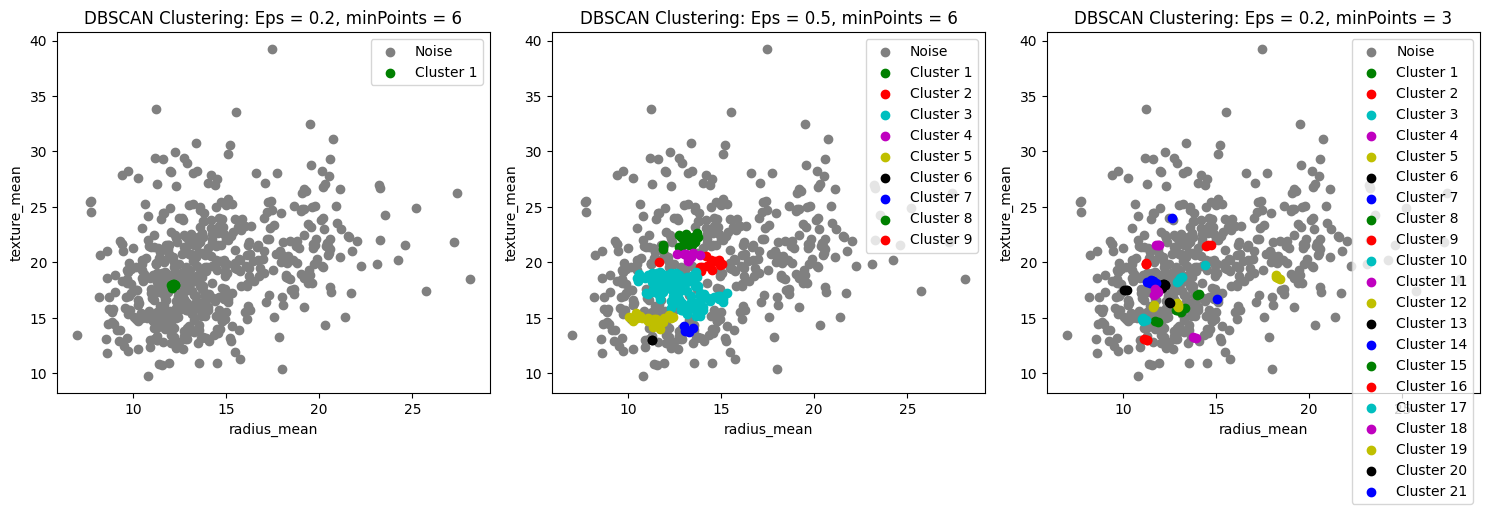

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import io

# Load the dataset
try:
  df = pd.read_csv('/content/cancer.csv')  # Load dataset from colab if available else upload
except:
  uploaded = files.upload()
  df = pd.read_csv(io.BytesIO(uploaded['cancer.csv']))

# Extract features excluding 'id' and 'diagnosis'
X = df.drop(columns=["id", "diagnosis"])
X = df.drop(['id', 'diagnosis'], axis=1)
X.fillna(0, inplace=True)
X.replace([np.inf, -np.inf], 1e9, inplace=True)
X = df[['radius_mean', 'texture_mean']].values

# Define the distance function (Euclidean distance)
def distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

# Perform DBSCAN clustering
def dbscan_clustering(X, eps, min_samples):
    n_samples = X.shape[0]
    visited = np.zeros(n_samples, dtype=bool)
    clusters = np.zeros(n_samples, dtype=int)
    cluster_count = 0

    for idx in range(n_samples):
        if visited[idx]:
            continue

        visited[idx] = True
        neighbors = []

        for i in range(n_samples):
            if distance(X[idx], X[i]) <= eps:
                neighbors.append(i)

        if len(neighbors) < min_samples:
            clusters[idx] = -1  # noise
        else:
            cluster_count += 1
            clusters[idx] = cluster_count
            expand_cluster(X, idx, neighbors, visited, clusters, eps, min_samples)

    unique_clusters = np.unique(clusters)
    return clusters, unique_clusters

# Expand the cluster
def expand_cluster(X, idx, neighbors, visited, clusters, eps, min_samples):
    for neighbor in neighbors:
        if not visited[neighbor]:
            visited[neighbor] = True
            neighbor_neighbors = []

            for i in range(X.shape[0]):
                if distance(X[neighbor], X[i]) <= eps:
                    neighbor_neighbors.append(i)

            if len(neighbor_neighbors) >= min_samples:
                neighbors.extend(neighbor_neighbors)

        if clusters[neighbor] == 0:
            clusters[neighbor] = clusters[idx]

# Perform DBSCAN clustering with Eps = 0.2, minPoints = 6
clusters_eps02_min06, unique_clusters_eps02_min06 = dbscan_clustering(X, eps=0.2, min_samples=6)

# Perform DBSCAN clustering with Eps = 0.5, minPoints = 6
clusters_eps05_min06, unique_clusters_eps05_min06 = dbscan_clustering(X, eps=0.5, min_samples=6)

# Perform DBSCAN clustering with Eps = 0.2, minPoints = 3
clusters_eps02_min03, unique_clusters_eps02_min03 = dbscan_clustering(X, eps=0.2, min_samples=3)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Create subplots for each DBSCAN clustering result
plt.figure(figsize=(15, 5))

# Plot the clusters with Eps = 0.2, minPoints = 6
plt.subplot(131)
for i, cluster in enumerate(unique_clusters_eps02_min06):
    if cluster == -1:
        plt.scatter(X[clusters_eps02_min06 == cluster, 0], X[clusters_eps02_min06 == cluster, 1], color='gray', label='Noise')
    else:
        plt.scatter(X[clusters_eps02_min06 == cluster, 0], X[clusters_eps02_min06 == cluster, 1], label=f'Cluster {cluster}', color=colors[i % len(colors)])
plt.xlabel('radius_mean')
plt.ylabel('texture_mean')
plt.title('DBSCAN Clustering: Eps = 0.2, minPoints = 6')
plt.legend()

# Plot the clusters with Eps = 0.5, minPoints = 6
plt.subplot(132)
for i, cluster in enumerate(unique_clusters_eps05_min06):
    if cluster == -1:
        plt.scatter(X[clusters_eps05_min06 == cluster, 0], X[clusters_eps05_min06 == cluster, 1], color='gray', label='Noise')
    else:
        plt.scatter(X[clusters_eps05_min06 == cluster, 0], X[clusters_eps05_min06 == cluster, 1], label=f'Cluster {cluster}', color=colors[i % len(colors)])
plt.xlabel('radius_mean')
plt.ylabel('texture_mean')
plt.title('DBSCAN Clustering: Eps = 0.5, minPoints = 6')
plt.legend()

# Plot the clusters with Eps = 0.2, minPoints = 3
plt.subplot(133)
for i, cluster in enumerate(unique_clusters_eps02_min03):
    if cluster == -1:
        plt.scatter(X[clusters_eps02_min03 == cluster, 0], X[clusters_eps02_min03 == cluster, 1], color='gray', label='Noise')
    else:
        plt.scatter(X[clusters_eps02_min03 == cluster, 0], X[clusters_eps02_min03 == cluster, 1], label=f'Cluster {cluster}', color=colors[i % len(colors)])
plt.xlabel('radius_mean')
plt.ylabel('texture_mean')
plt.title('DBSCAN Clustering: Eps = 0.2, minPoints = 3')
plt.legend()

plt.tight_layout()
plt.show()

#Hierarchical Agglomerative Clustering#


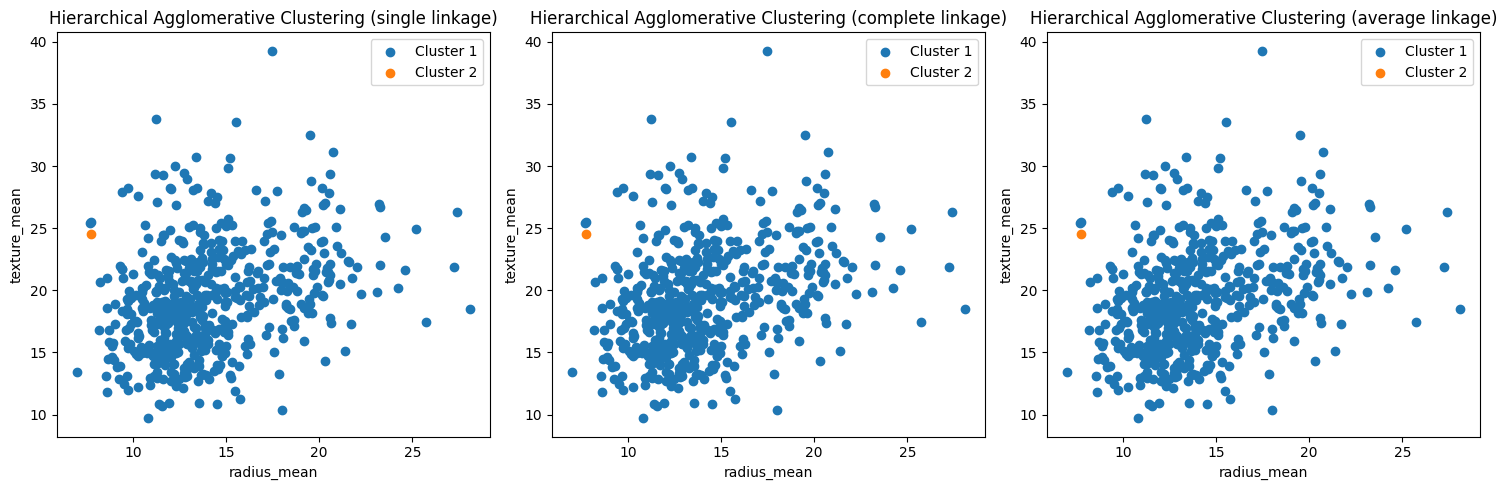

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import io

# Load the dataset
try:
  df = pd.read_csv('/content/cancer.csv')  # Load dataset from colab if available else upload
except:
  uploaded = files.upload()
  df = pd.read_csv(io.BytesIO(uploaded['cancer.csv']))

# Extract the relevant attributes for clustering (excluding "id" and "diagnosis")
X = df.drop(columns=["id", "diagnosis"])
X = df.drop(['id', 'diagnosis'], axis=1)
X.fillna(0, inplace=True)
X.replace([np.inf, -np.inf], 1e9, inplace=True)
X = df[['radius_mean', 'texture_mean']].values    # Convert to NumPy array for easier manipulation

# Define a custom hierarchical agglomerative clustering function
def hierarchical_agglomerative_clustering(X, num_clusters, linkage):
    n, m = X.shape     # n samples, m features
    clusters = [[i] for i in range(n)]
    distances = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):
            # Calculate the distance between clusters based on the specified linkage method
            if linkage == 'single':
                distances[i, j] = np.min(np.linalg.norm(X[clusters[i]] - X[clusters[j]], axis=1))
            elif linkage == 'complete':
                distances[i, j] = np.max(np.linalg.norm(X[clusters[i]] - X[clusters[j]], axis=1))
            elif linkage == 'average':
                distances[i, j] = np.mean(np.linalg.norm(X[clusters[i]] - X[clusters[j]], axis=1))
            distances[j, i] = distances[i, j]  # Distance matrix is symmetric

    while len(clusters) > num_clusters:
        # Find the indices of the two clusters to merge
        min_distance_idx = np.unravel_index(np.argmin(distances), distances.shape)
        i, j = min_distance_idx

        # Merge the two clusters
        clusters[i].extend(clusters[j])
        del clusters[j]
        distances = np.delete(distances, j, axis=0)
        distances = np.delete(distances, j, axis=1)

        # Recalculate distances to the merged cluster based on the linkage method
        for k in range(len(clusters) - 1):
            if linkage == 'single':
                distances[i, k] = np.min(np.linalg.norm(X[clusters[i]] - X[clusters[k]], axis=1))
            elif linkage == 'complete':
                distances[i, k] = np.max(np.linalg.norm(X[clusters[i]] - X[clusters[k]], axis=1))
            elif linkage == 'average':
                distances[i, k] = np.mean(np.linalg.norm(X[clusters[i]] - X[clusters[k]], axis=1))
            distances[k, i] = distances[i, k]

    cluster_labels = np.zeros(n)
    for cluster_idx, cluster in enumerate(clusters):
        cluster_labels[cluster] = cluster_idx

    return cluster_labels

# Perform hierarchical agglomerative clustering with different linkage methods
num_clusters = 2
linkage_methods = ['single', 'complete', 'average']

plt.figure(figsize=(15, 5))

for i, linkage_method in enumerate(linkage_methods):
    plt.subplot(1, 3, i + 1)

    # Perform hierarchical agglomerative clustering
    cluster_labels = hierarchical_agglomerative_clustering(X, num_clusters, linkage_method)

    for cluster in range(num_clusters):
        plt.scatter(
            X[cluster_labels == cluster, 0],
            X[cluster_labels == cluster, 1],
            label=f'Cluster {cluster + 1}'
        )

    plt.xlabel('radius_mean')
    plt.ylabel('texture_mean')
    plt.title(f'Hierarchical Agglomerative Clustering ({linkage_method} linkage)')
    plt.legend()

plt.tight_layout()
plt.show()
